# Correlation Analysis

Implement a Study of the critical phase by analyzing the synthetic correlation functions

#### Imports

In [1]:
import os
import time
from turtle import position

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import tqdm, trange

from src.training.utils_analysis import dataloader, nuv_representability_check

## Case a) The Correlation average order parameter $\langle \frac{1}{N^2}\sum^{N}_{i,j} C_{i,j} \rangle_{dis}= g$

#### Data

In [2]:
batch=1000 #number of samples
nbatch=10
minibatch=int(batch/nbatch)
ls=[16,32,64,128]
h_max=[1.0,1.8,2.7,3.6,4.5]
device='cpu'
torch.set_num_threads(10)


op_l=[]
op_ml_l=[]
for l in ls:
    op=[]
    op_ml=[]
    for i in trange(len(h_max)):
        data=np.load(f'data/correlation_1nn_rebuilt/test_1nn_correlation_map_h_{h_max[i]}_1000_l_{l}_pbc_j_1.0.npz')
        z=data['density'][:batch]
        xx=data['correlation'][:batch]
        
        if i!=0 :
            z_torch=torch.tensor(z,dtype=torch.double,device=device)
            print(z.shape)
            #model=torch.load(f'model_rep/1nn_den2cor/h_{h_max}_150k_unet_periodic_den2corRESNET_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock',map_location='cpu')
            model=torch.load(f'model_rep/1nn_den2cor/h_{h_max[i]}_150k_unet_periodic_den2corLSTM_scalable_[20, 40]_hc_5_ks_2_ps_2_nconv_0_nblock',map_location=device)

            model.eval()


            for j in trange(nbatch):
                #print(i)
                x=model(z_torch[minibatch*j:minibatch*(j+1)]).cpu().detach().numpy()
                if j==0:
                    xx_ml=x
                else:
                    xx_ml=np.append(xx_ml,x,axis=0)    

        op.append(np.average(xx))
        
        if i==0 :
            op_ml.append(np.average(xx))
        else:
            op_ml.append(np.average(xx_ml))


    op_ml_l.append(np.asarray(op_ml))
    op_l.append(np.asarray(op))


    

    

  0%|          | 0/5 [00:00<?, ?it/s]

(900, 16)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 16)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 16)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 16)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(900, 32)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 32)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 32)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 32)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(900, 64)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 64)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 64)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 64)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(900, 128)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 128)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 128)


  0%|          | 0/10 [00:00<?, ?it/s]

(900, 128)


  0%|          | 0/10 [00:00<?, ?it/s]

#### Plot

[16, 32, 64, 128]


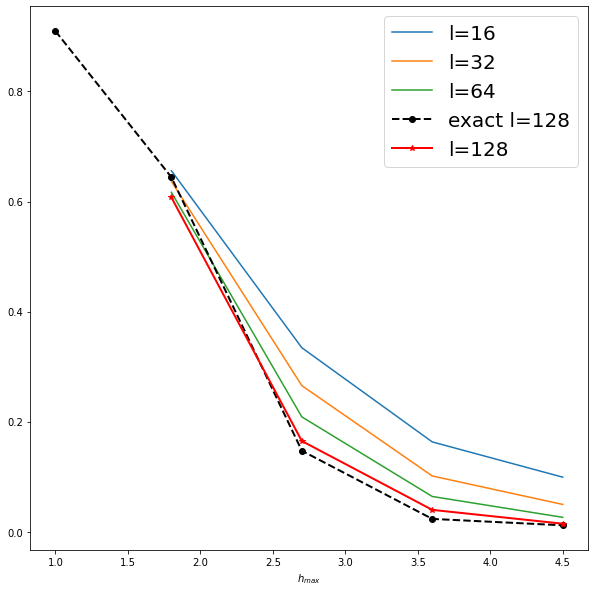

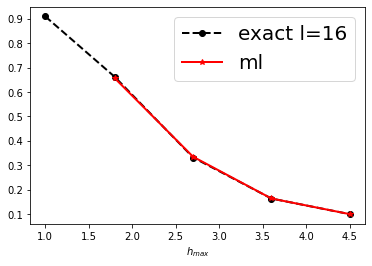

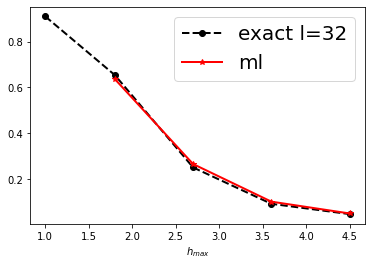

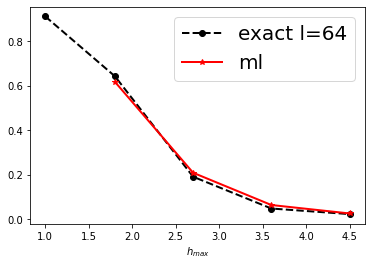

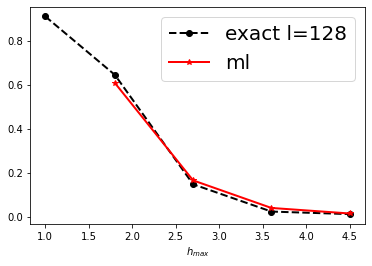

In [6]:

plt.figure(figsize=(10,10))
print(ls)
for i in range(len(ls)):
    #plt.plot(h_max,op_l[i],label=f'exact l={ls[i]}')
    if ls[i]==128:
        plt.plot(h_max,op_l[i],label='exact l=128',linestyle='--',linewidth=2,color='black',marker='o')
        plt.plot(h_max[1:],op_ml_l[i][1:],label=f'l={ls[i]}',color='red',linewidth=2,marker='*')
    else:
        plt.plot(h_max[1:],op_ml_l[i][1:],label=f'l={ls[i]}')
    
plt.legend(fontsize=20)
plt.xlabel(r'$h_{max}$')
plt.show()

for i in range(len(ls)):
    plt.plot(h_max,op_l[i],label=f'exact l={ls[i]}',linestyle='--',linewidth=2,color='black',marker='o')
    plt.plot(h_max[1:],op_ml_l[i][1:],label=f'ml',color='red',linewidth=2,marker='*')
    
    plt.legend(fontsize=20)
    plt.xlabel(r'$h_{max}$')
    plt.show()

## Case b) The critical exponent of the correlation function in the Phase transition

Looking at the Phase Diagram of $g$ we can suspect that around $h_max=e$ there is a Phase transition. To have confirm of this behaviour we can compare the power law behaviour of the synthetic Correlation function to the exact one, predicted in the article, with 

$g(r)=\frac{1}{N}\sum_i C_{i,i+r} \sim\frac{1}{r^{2-\phi}} \; \; \text{with} \; \; \phi=\frac{1+\sqrt{5}}{2} \; \; \text{when} \; \; h_{max}=e$

#### Data

In [3]:
batch=100
nbatch=1
minibatch=int(batch/nbatch)
ls=[16,32,64,128]
h_max=2.7
device='cpu'
torch.set_num_threads(3)


g_l=[]
g_ml_l=[]
for l in ls:
    
        data=np.load(f'data/correlation_1nn_rebuilt/test_1nn_correlation_map_h_{h_max}_1000_l_{l}_pbc_j_1.0.npz')
        z=data['density'][:batch]
        xx=data['correlation'][:batch]
        
        
        z_torch=torch.tensor(z,dtype=torch.double,device=device)
        print(z.shape)
        #model=torch.load(f'model_rep/1nn_den2cor/h_{h_max}_150k_unet_periodic_den2corRESNET_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock',map_location='cpu')
        model=torch.load(f'model_rep/1nn_den2cor/h_{h_max}_150k_unet_periodic_den2corLSTM_scalable_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock',map_location=device)

        model.eval()
    
        for j in trange(nbatch):
                x=model(z_torch[minibatch*j:minibatch*(j+1)]).cpu().detach().numpy()
                if j==0:
                    xx_ml=x
                else:
                    xx_ml=np.append(xx_ml,x,axis=0)
                    
        g=np.average(xx,axis=-1)
        g_ml=np.average(xx_ml,axis=-1)
        g=np.average(g,axis=0) #av over the disorder
        g_ml=np.average(g_ml,axis=0) #av over the disorder
        
        g_l.append(g)
        g_ml_l.append(g_ml)



(100, 16)


  0%|          | 0/1 [00:00<?, ?it/s]

(100, 32)


  0%|          | 0/1 [00:00<?, ?it/s]

(100, 64)


  0%|          | 0/1 [00:00<?, ?it/s]

(100, 128)


  0%|          | 0/1 [00:00<?, ?it/s]

#### Plot

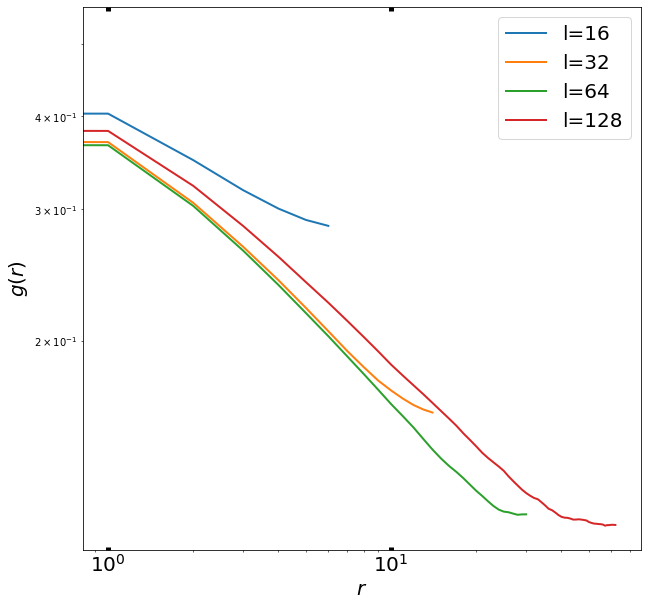

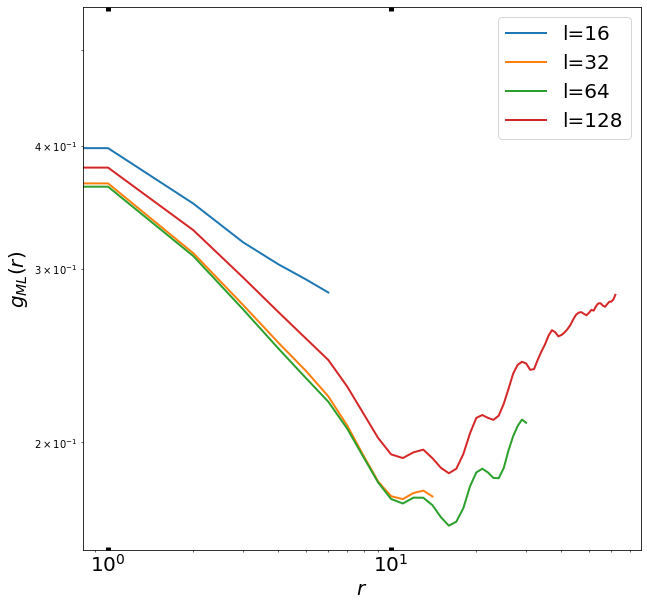

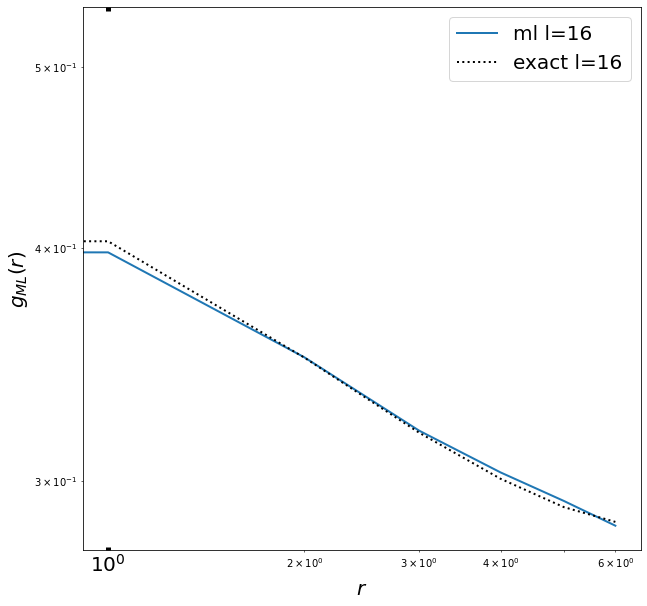

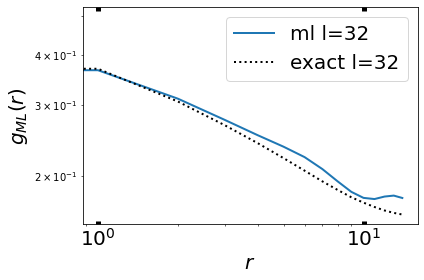

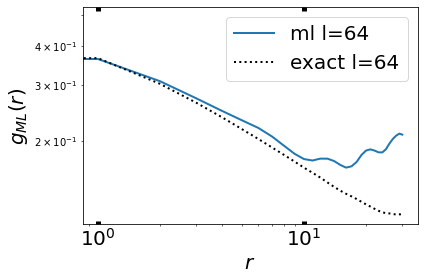

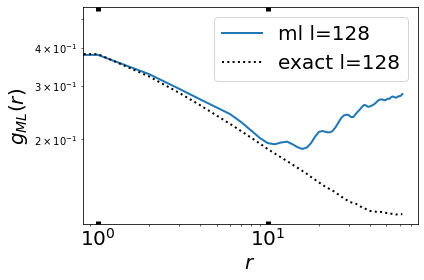

In [4]:
figure=plt.figure(figsize=(10,10))
for i in range(len(g_l)):
    plt.plot(g_l[i],label=f'l={ls[i]}',linewidth=2)
plt.loglog()
plt.xlabel(r'$r$',fontsize=20)
plt.ylabel(r'$g(r)$',fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=5,
        )
plt.show()

figure=plt.figure(figsize=(10,10))
for i in range(len(g_l)):
    plt.plot(g_ml_l[i],label=f'l={ls[i]}',linewidth=2)
plt.loglog()
plt.xlabel(r'$r$',fontsize=20)
plt.ylabel(r'$g_{ML}(r)$',fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=5,
        )
plt.show()

figure=plt.figure(figsize=(10,10))
for i in range(len(g_l)):
    plt.plot(g_ml_l[i],label=f'ml l={ls[i]}',linewidth=2)
    plt.plot(g_l[i],label=f'exact l={ls[i]}',linewidth=2,linestyle=':',color='black')
    plt.loglog()
    plt.xlabel(r'$r$',fontsize=20)
    plt.ylabel(r'$g_{ML}(r)$',fontsize=20)
    plt.legend(fontsize=20)
    plt.tick_params(
                top=True,
                right=True,
                labeltop=False,
                labelright=False,
                direction="in",
                labelsize=20,
                width=5,
            )
    plt.show()

#### Find the critical exponent by a synthetic correlation function 

In [6]:
from scipy import stats
x=np.arange(int(128/2 -1))

slope_0, intercept, r_value, p_value, std_err = stats.linregress(np.log(x[7:35]), np.log(g_l[-1])[7:35])

print(slope_0,intercept,r_value)

slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = stats.linregress(np.log(x[7:35]), np.log(g_ml_l[-1])[7:35])

print(slope_1,intercept,r_value)

-0.36000646810186465 -0.8522509941470497 -0.9995717248517827
0.12969485024282076 -0.8522509941470497 -0.9995717248517827


## Accuracy of the Neural Network

#### Data

In [7]:
batch=100 #number of samples
nbatch=10
minibatch=int(batch/nbatch)
ls=[16,32,64,128]
h_max=[2.7]
device='cpu'
torch.set_num_threads(10)


dxx_l=[]
for l in ls:
    dxx=[]
    for i in trange(len(h_max)):
        data=np.load(f'data/correlation_1nn_rebuilt/test_1nn_correlation_map_h_{h_max[i]}_1000_l_{l}_pbc_j_1.0.npz')
        z=data['density'][:batch]
        xx=data['correlation'][:batch]
        
        z_torch=torch.tensor(z,dtype=torch.double,device=device)
        print(z.shape)
        #model=torch.load(f'model_rep/1nn_den2cor/h_{h_max}_150k_unet_periodic_den2corRESNET_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock',map_location='cpu')
        model=torch.load(f'model_rep/1nn_den2cor/h_{h_max[i]}_150k_unet_periodic_den2corLSTM_scalable_[20, 40]_hc_5_ks_2_ps_2_nconv_0_nblock',map_location=device)

        model.eval()


        for j in trange(nbatch):
            #print(i)
            x=model(z_torch[minibatch*j:minibatch*(j+1)]).cpu().detach().numpy()
            if j==0:
                xx_ml=x
            else:
                xx_ml=np.append(xx_ml,x,axis=0) 
        
        dxx.append(np.average(np.average(np.abs(xx-xx_ml),axis=(-1,-2))/np.average(np.abs(xx),axis=(-1,-2))))
    dxx=np.asarray(dxx)
    dxx_l.append(dxx)
        
           

        

  0%|          | 0/1 [00:00<?, ?it/s]

(100, 16)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(100, 32)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(100, 64)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(100, 128)


  0%|          | 0/10 [00:00<?, ?it/s]

#### Plots

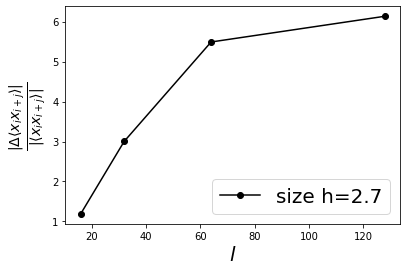

In [8]:
dxx_l=np.asarray(dxx_l)
for i in range(len(h_max)):
    plt.plot(ls,dxx_l[:,i],marker='o',label=f'size h={h_max[i]}',color='black')
    plt.legend(fontsize=20)
    plt.xlabel(r'$l$',fontsize=20)
    plt.ylabel(r'$\frac{|\Delta \langle x_i x_{i+j} \rangle|}{|\langle x_i x_{i+j} \rangle |}$',fontsize=20)
    plt.show()